# Test

In [1]:
%load_ext autoreload
%autoreload 2

### Import datasets

Import datasets using functions from src/data/data.py. Datasets are downloaded from huggingface and stored in /data. Once downloaded, datasets are loaded locally.

Run ```pip install -e .``` if module importing isn't working.

In [2]:
from src.data.data import get_in_domain, get_out_domain
from src.data.data import get_random_subsets

in_domain_train, in_domain_test = get_in_domain()
out_domain = get_out_domain()

print(f"In domain:\n{in_domain_train}")
print(in_domain_train[0])

print(f"Out of domain:\n{out_domain}")
print(out_domain[10])

# get_random_subsets(in_domain)

c:\Users\harri\anaconda3\envs\fine-tuning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In domain:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})
{'premise': 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'hypothesis': 'You lose the things to the following level if the people recall.', 'label': 0, 'idx': 1}
Out of domain:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 10000
})
{'premise': 'The president avoided the athlete .', 'hypothesis': 'The athlete avoided the president .', 'label': 1, 'parse_premise': '(ROOT (S (NP (DT The) (NN president)) (VP (VBD avoided) (NP (DT the) (NN athlete))) (. .)))', 'parse_hypothesis': '(ROOT (S (NP (DT The) (NN at

### Import models

Import models using methods from src/models/opt.py. Models are downloaded from huggingface and stored in /models/pretrained. Once downloaded, models are loaded locally.

In [3]:
from src.model.model import get_model

model_opt125, tokenizer_opt125 = get_model('opt-125m')
model_opt350, tokenizer_opt350 = get_model('opt-350m')

### Few-shot finetuning

Perform few-shot fine-tuning using the fine_tune method from /src/finetuners/fewshot.py. This method requires model, tokenizers, and datasets to be passed in as parameters. It returns training and evaluation metrics.

In [4]:
from src.finetuners.fewshot import fine_tune

train_dataset = in_domain_train.select(range(2))
eval_dataset_in = in_domain_test.select(range(2))
eval_dataset_out = out_domain.select(range(2))

fine_tune(model=model_opt125, tokenizer=tokenizer_opt125, train_dataset=train_dataset, eval_dataset_in=eval_dataset_in, eval_dataset_out=eval_dataset_out)

100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


{'train_runtime': 12.6058, 'train_samples_per_second': 6.346, 'train_steps_per_second': 3.173, 'train_loss': 0.061122357845306396, 'epoch': 40.0, 'train_peak_memory_gb': 2.502718925476074}


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


{'train_runtime': 12.6058,
 'train_samples_per_second': 6.346,
 'train_steps_per_second': 3.173,
 'train_loss': 0.061122357845306396,
 'epoch': 40.0,
 'train_peak_memory_gb': 2.502718925476074,
 'eval_in_loss': 3.377666473388672,
 'eval_in_accuracy': 0.5,
 'eval_in_runtime': 2.4477,
 'eval_in_samples_per_second': 0.817,
 'eval_in_steps_per_second': 0.409,
 'eval_in_peak_memory_gb': 1.5613317489624023,
 'eval_out_loss': 5.777809143066406,
 'eval_out_accuracy': 0.0,
 'eval_out_runtime': 2.3399,
 'eval_out_samples_per_second': 0.855,
 'eval_out_steps_per_second': 0.427,
 'eval_out_peak_memory_gb': 1.5613317489624023}

### Batch few-shot finetuning

Perform batch few-shot fine-tuning using batch_fine_tune from /src/finetuners/fewshot.py. This method only requires model_name and training and eval datasets. The selected model is loaded from /models/pretrained for each trial to prevent cumulative fine-tuning. sample_sizes corresponds to the number of shots used for each trial. Each trial is trained and evaluated using data randomly selected by get_random_subsets from /src/utils.py. Results are written to a csv in /logs.

In [5]:
import json
from src.finetuners.fewshot import batch_fine_tune
from src.data.data import get_random_subsets

# Generate training and evaluation datasets. These should be used for all fine-tuning methods to ensure consistency. np.random should be seeded before this.
train_datasets, eval_dataset_in, eval_dataset_out = get_random_subsets(train_dataset=in_domain_train, 
                                                                       eval_dataset_in=in_domain_test, 
                                                                       eval_dataset_out=out_domain, 
                                                                       train_sample_sizes=[2, 4, 6, 8, 16],#[2, 16, 32, 64, 128], # [2, 4],
                                                                       num_trials=10,   # 5
                                                                       eval_sample_size=50) # 10

results = batch_fine_tune(model_name='opt-125m', train_datasets=train_datasets, eval_dataset_in=eval_dataset_in, eval_dataset_out=eval_dataset_out)

print(json.dumps(results, indent=4))

16-shot: 100%|██████████| 10/10 [3:30:47<00:00, 1264.72s/it, train_runtime=1.19e+3, train_samples_per_second=0.539, train_steps_per_second=0.034, total_flos=1.67e+14, train_loss=0.12, epoch=40, train_peak_memory_gb=10.4, eval_in_loss=2.54, eval_in_accuracy=0.42, eval_in_runtime=29.5, eval_in_samples_per_second=1.69, eval_in_steps_per_second=0.237, eval_in_peak_memory_gb=2.44, eval_out_loss=2.52, eval_out_accuracy=0.44, eval_out_runtime=29.6, eval_out_samples_per_second=1.69, eval_out_steps_per_second=0.236, eval_out_peak_memory_gb=2.44]   

{
    "2": [
        {
            "train_runtime": 9.3668,
            "train_samples_per_second": 8.541,
            "train_steps_per_second": 4.27,
            "total_flos": 20903740047360.0,
            "train_loss": 0.09622114300727844,
            "epoch": 40.0,
            "train_peak_memory_gb": 2.9804773330688477,
            "eval_in_loss": 0.9207779169082642,
            "eval_in_accuracy": 0.48,
            "eval_in_runtime": 5.1078,
            "eval_in_samples_per_second": 9.789,
            "eval_in_steps_per_second": 1.37,
            "eval_in_peak_memory_gb": 2.4387974739074707,
            "eval_out_loss": 0.7284060120582581,
            "eval_out_accuracy": 0.48,
            "eval_out_runtime": 3.8623,
            "eval_out_samples_per_second": 12.946,
            "eval_out_steps_per_second": 1.812,
            "eval_out_peak_memory_gb": 2.4387974739074707
        },
        {
            "train_runtime": 9.6224,
            "train_samples_per_second": 8.314,
       

### Plot in domain vs out of domain metrics

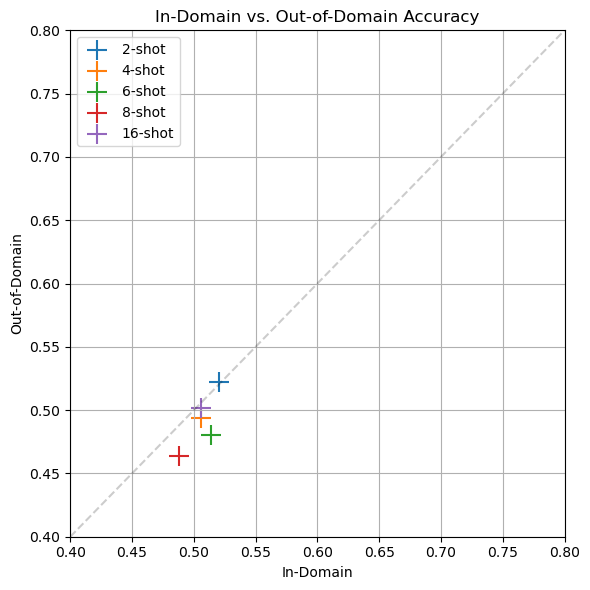

In [23]:
from src.visualization.plot import plot_in_out_domain

plot_in_out_domain(logfile='opt-125m_fewshot_2_4_6_8_16', metric='accuracy')
plot_in_out_domain(logfile='opt-125m_fewshot_2_4_6_8_16', metric='peak_memory_gb')